# GAN Implementation

Python version: 3.8.8

In [39]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# create directory to save results
!mkdir GAN_results

# script parameters
batch_size = 128
log_interval = 200

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)


mkdir: GAN_results: File exists


In [40]:
# Generator Network
class Generator(nn.Module):

    # declare layers
    def __init__(self):
        super(Generator, self).__init__()

        self.fc1 = nn.Linear(20, 400)
        self.fc2 = nn.Linear(400, 784)

    # Forward: one ReLU hidden layer of 400 nodes, one Sigmoid output layer of 784 nodes
    def forward(self, z):
        h = F.relu(self.fc1(z.view(-1,20)))
        probabilities = torch.sigmoid(self.fc2(h))
        return probabilities

# Discriminator Network
class Discriminator(nn.Module):

    # declare layers
    def __init__(self):
        super(Discriminator, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 1)

    # Forward: one ReLU hidden layer of 400 nodes, one Sigmoid output layer of 1 node
    def forward(self, x):
        h = F.relu(self.fc1(x.view(-1, 784)))
        probabilities = torch.sigmoid(self.fc2(h))
        return probabilities


## Loss Function

In [41]:
# GAN Loss Function
#
# Inputs:
#    predictions: array of probabilities indicating whether the images are real or fake
#    targets: array of 1s (real image) and 0s (fake image)
#
# Output:
#    BCE: binary cross entropy (scalar)
#
def gan_loss_function(predictions, targets):

    BCE = F.binary_cross_entropy(predictions, targets, reduction='sum')
    return BCE


## Training

In [44]:
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.
epochs = 50

# GAN Training
#
# Have a look at the following tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#
# Inputs:
#    epoch: epoch #
#    generator: generator network
#    generator_optimizer: generator optimizer
#    discriminator: discriminator network
#    discriminator_optimizer: discriminator optimizer
#
# Outputs:
#    average_generator_loss: binary cross entropy (scalar)
#    average_discriminator_loss: binary cross entropy (scalar)
#
def gan_train(epoch, generator, generator_optimizer, discriminator, discriminator_optimizer):
    generator.train()
    discriminator.train()
    gen_loss = 0
    disc_loss = 0
    for i, data in enumerate(train_loader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator_optimizer.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = discriminator(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = gan_loss_function(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 20, 1, 1, device=device)
        # Generate fake image batch with G
        fake = generator(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = gan_loss_function(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        discriminator_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator_optimizer.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = gan_loss_function(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        generator_optimizer.step()

        # Output training stats
        if i % log_interval == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        gen_loss += errG.item()
        disc_loss += errD.item()
    
    average_discriminator_loss = gen_loss / len(train_loader.dataset)
    average_generator_loss = disc_loss / len(train_loader.dataset)
    print('====> Train set Loss_G: {:.4f}, Train set Loss_D: {:.4f}'.format(
        average_generator_loss, average_discriminator_loss))
    return average_generator_loss, average_discriminator_loss


## Testing

In [43]:
# GAN Test
#
# Have a look at the following tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#
# Inputs:
#    epoch: epoch #
#    generator: generator network
#    discriminator: discriminator network
#
# Outputs:
#    average_generator_loss: binary cross entropy (scalar)
#    average_discriminator_loss: binary cross entropy (scalar)
#
def gan_test(epoch, generator, discriminator):
    generator.eval()
    discriminator.eval()
    gen_loss, disc_loss = 0,0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label,
                            dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = discriminator(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = gan_loss_function(output, label)
            # Calculate gradients for D in backward pass
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, 20, 1, 1, device=device)
            # Generate fake image batch with G
            fake = generator(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = discriminator(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = gan_loss_function(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = discriminator(fake).view(-1)
            # Calculate G's loss based on this output
            errG = gan_loss_function(output, label)
            # Calculate gradients for G
            D_G_z2 = output.mean().item()

            # Output training stats
            if i % log_interval == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, epochs, i, len(test_loader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            gen_loss += errG.item()
            disc_loss += errD.item()

    average_generator_loss = gen_loss / len(test_loader.dataset)
    average_discriminator_loss = disc_loss / len(test_loader.dataset)
    print('====> Test set Loss_G: {:.4f}, Test set Loss_D: {:.4f}'.format(
        average_generator_loss, average_discriminator_loss))
    return average_generator_loss, average_discriminator_loss


## Main

Starting Training Loop 1...
[1/50][0/469]	Loss_D: 180.0886	Loss_G: 108.9075	D(x): 0.5109	D(G(z)): 0.5205 / 0.4271
[1/50][200/469]	Loss_D: 75.2802	Loss_G: 288.9159	D(x): 0.6908	D(G(z)): 0.1495 / 0.1205
[1/50][400/469]	Loss_D: 25.0446	Loss_G: 368.3047	D(x): 0.9048	D(G(z)): 0.0775 / 0.0592
====> Train set Loss_G: 0.3691, Train set Loss_D: 2.6774
Starting Testing Loop 1...
[1/50][0/79]	Loss_D: 14.3977	Loss_G: 398.5593	D(x): 0.9420	D(G(z)): 0.0473 / 0.0473
====> Test set Loss_G: 3.0949, Test set Loss_D: 0.1092


Starting Training Loop 2...
[2/50][0/469]	Loss_D: 15.9567	Loss_G: 427.4804	D(x): 0.9356	D(G(z)): 0.0482 / 0.0374
[2/50][200/469]	Loss_D: 14.9371	Loss_G: 432.1772	D(x): 0.9474	D(G(z)): 0.0528 / 0.0393
[2/50][400/469]	Loss_D: 8.7076	Loss_G: 484.6450	D(x): 0.9723	D(G(z)): 0.0369 / 0.0252
====> Train set Loss_G: 0.1144, Train set Loss_D: 3.4390
Starting Testing Loop 2...
[2/50][0/79]	Loss_D: 15.4489	Loss_G: 404.3744	D(x): 0.9451	D(G(z)): 0.0538 / 0.0538
====> Test set Loss_G: 3.2015, Te

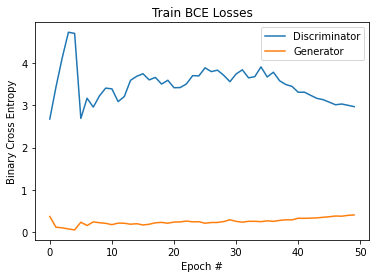

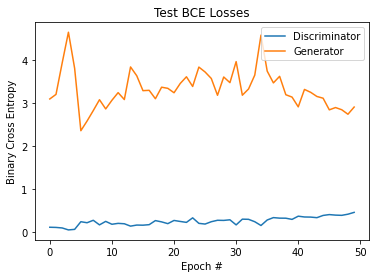

In [50]:
# train and test gan
discriminator_average_train_losses = []
discriminator_average_test_losses = []
generator_average_train_losses = []
generator_average_test_losses = []
generator_model = Generator().to(device)
generator_optimizer = optim.Adam(generator_model.parameters(), lr=2e-4)
discriminator_model = Discriminator().to(device)
discriminator_optimizer = optim.Adam(discriminator_model.parameters(), lr=2e-4)
for epoch in range(1, epochs + 1):
    print(f"Starting Training Loop {epoch}...")
    generator_average_train_loss, discriminator_average_train_loss = gan_train(
        epoch, generator_model, generator_optimizer, discriminator_model, discriminator_optimizer)
    discriminator_average_train_losses.append(discriminator_average_train_loss)
    generator_average_train_losses.append(generator_average_train_loss)
    print(f"Starting Testing Loop {epoch}...")
    generator_average_test_loss, discriminator_average_test_loss = gan_test(
        epoch, generator_model, discriminator_model)
    discriminator_average_test_losses.append(discriminator_average_test_loss)
    generator_average_test_losses.append(generator_average_test_loss)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = generator_model(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'GAN_results/sample_' + str(epoch) + '.png')
    print('\n')

# Plot Train losses
plt.plot(discriminator_average_train_losses)
plt.plot(generator_average_train_losses)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator', 'Generator'], loc='upper right')
plt.show()

# Plot Test Losses
plt.plot(discriminator_average_test_losses)
plt.plot(generator_average_test_losses)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator', 'Generator'], loc='upper right')
plt.show()


## Generated Image Comparison

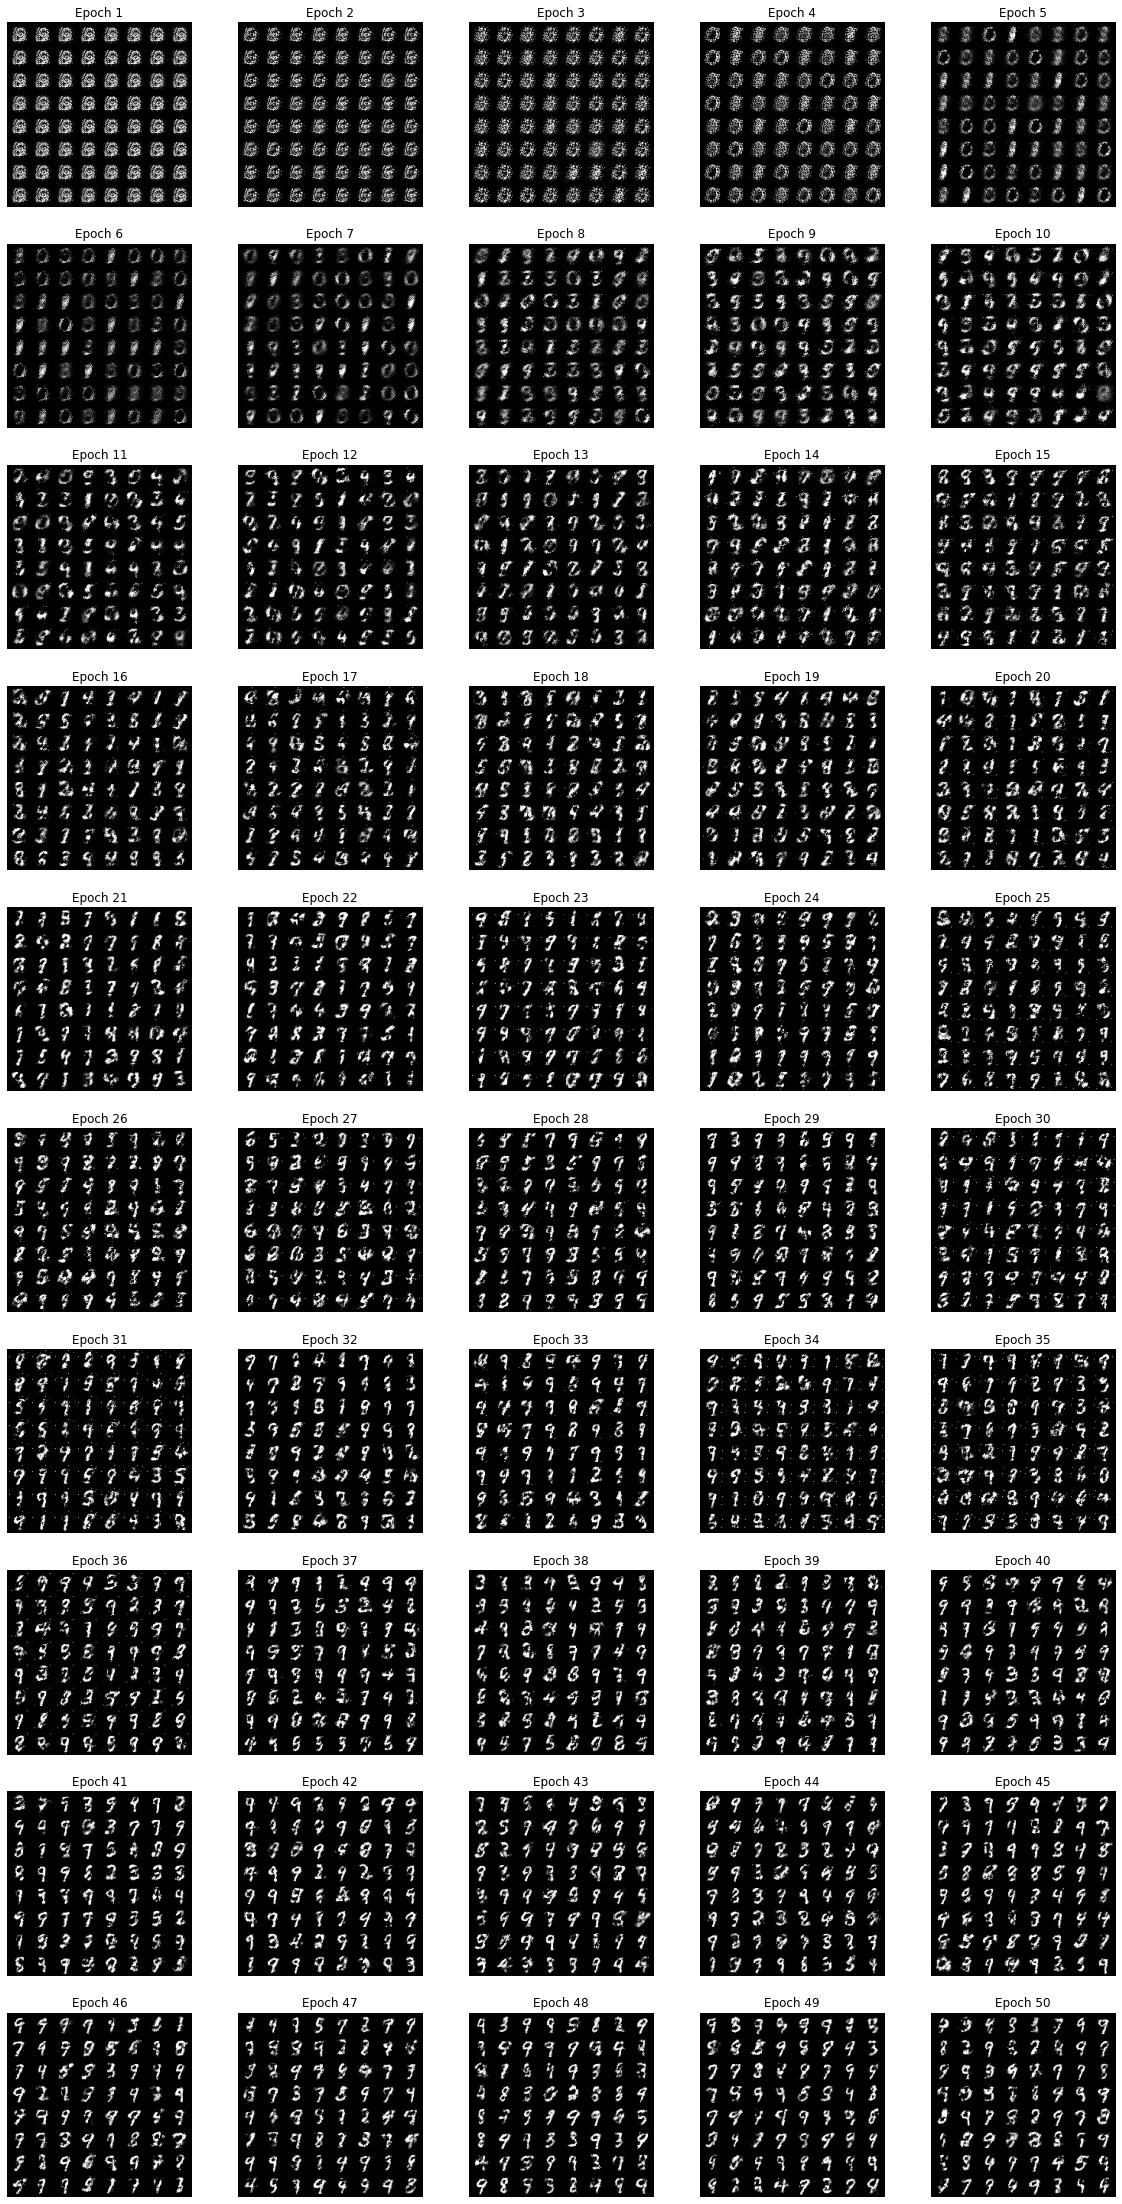

In [51]:
_, axis = plt.subplots(10, 5, figsize=(20, 40))

# display images
for e in range(epochs):
    img = mpimg.imread('GAN_results/sample_' + str(e+1) + '.png')
    axis[e//5, e%5].imshow(img)
    axis[e//5, e%5].axis('off')
    axis[e//5, e%5].set_title(f"Epoch {e+1}")
plt.show()


GAN generates the best images, VAE is the second, and DAE generates the worst images. From the images generated by VAE, you can see the numbers, but the edges are pretty blurred, and for many images it's hard to identify which number it is. In contrast, the GAN produced images have a sharper edge and we can identify most numbers clearly. We've explained in Exercise 1 why VAE generates better image than DAE. GAN performs better because the generator learns the pattern by producing fake images, and the discriminator identifies the fake images from the real images. The more iterations it go through, the closer (smaller the loss) its generated images are to the real images, since the discriminator is getting better and better as sell.

## Use images generated by GAN to train a CNN classifier

I think I can use the images generated by GAN to train the CNN classifier, so that it can be more accurate in identifying numbers from images. With more iterations and more complicated network, GAN can produce images mostly identical to the real image, but there's still slight differencec between the fake and real images. The generated images give the CNN classifier more patterns to observe and thus might improve the classification accuracy. 

I think I can get similar improvements with VAE, but not with DAE, since DAE generates images very different from real images. If we use a more complex network, VAE can generate images very close to the real images and thus could improve the accuracy of CNN classification.